#### Lake level extraction by using swot_l2_hr_raster data 
Processing workflow：   
(1) data reading;  
(2) outliers removing;    
(3) time-series water level calculation.

In [1]:
import os
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from utils.functions import IQR_filter
from utils.transform_time import dt64_to_dyr


#### 1. data check

In [2]:
dir_save = 'data/dianchi_lake/raster'
path_lake_vec = 'data/dianchi_lake/dianchi_vector.gpkg'


In [3]:
## Check original .nc raster file.
paths_file = [os.path.join(dir_save, file) for file in os.listdir(dir_save) if 'Raster_100m_' in file and 'masked.nc' in file]
paths_file = sorted(paths_file)
print(paths_file[0])
raster_nc = xr.open_dataset(paths_file[0], decode_times=False)
raster_nc


data/dianchi_lake/raster/SWOT_L2_HR_Raster_100m_UTM48R_N_x_x_x_009_049_099F_20240105T211638_20240105T211659_PGC0_01_masked.nc


<xarray.Dataset>
Dimensions:   (x: 196, y: 310)
Coordinates:
  * x         (x) float64 102.6 102.6 102.6 102.6 ... 102.8 102.8 102.8 102.8
  * y         (y) float64 24.96 24.96 24.96 24.96 ... 24.67 24.67 24.67 24.67
Data variables:
    crs       int64 ...
    wse       (y, x) float32 ...
    sig0      (y, x) float32 ...
    geoid     (y, x) float32 ...
    wse_qual  (y, x) float32 ...
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    institution:                   JPL
    source:                        Ka-band radar interferometer
    history:                       2024-07-16T20:15:39Z : Creation
    platform:                      SWOT
    ...                            ...
    mgrs_latitude_band:            R
    x_min:                         196100.0
    x_max:                         346100.0
    y_min:                         2644900.0
    y_max:                         2794800.0
    product_version:               01

In [4]:
## read vector file of the lake.
dianchi_gpd = gpd.read_file(path_lake_vec)
dianchi_gpd


,Name,geometry
0,dianchi,"POLYGON Z ((102.66614 24.83805 0.00000, 102.65..."


In [5]:
raster_extent = [raster_nc.x.min().values, raster_nc.x.max().values,
                 raster_nc.y.min().values, raster_nc.y.max().values]

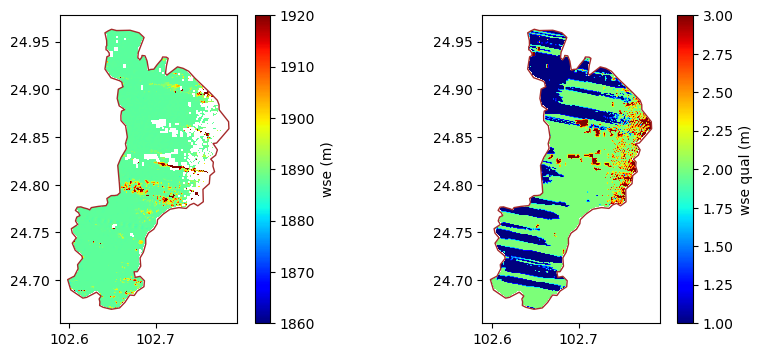

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
## ax0
im0 = ax[0].imshow(raster_nc.wse.values, 
                   cmap='jet', extent=raster_extent, vmax=1920, vmin=1860)
dianchi_gpd.plot(ax=ax[0], edgecolor='Brown', facecolor='none', linewidth=1)

## ax1
im1 = ax[1].imshow(raster_nc.wse_qual.values, 
                   cmap='jet', extent=raster_extent)
dianchi_gpd.plot(ax=ax[1], edgecolor='Brown', facecolor='none', linewidth=1)

fig.colorbar(im0).set_label('wse (m)')
fig.colorbar(im1).set_label('wse qual (m)')


#### (2) Outlier removing using IQR method.

In [10]:
wse_IQR, IQR = IQR_filter(raster_nc.wse.values)
print(IQR)
iter = 0
while IQR > 0.5:    
    iter += 1
    wse_IQR_mask = wse_IQR.mask
    wse_IQR, IQR = IQR_filter(wse_IQR.filled(np.nan))
    wse_IQR.mask = wse_IQR.mask | wse_IQR_mask
    if iter == 3: break   ## max iteration: 4 times.
print(IQR)



0.154815673828125
0.154815673828125


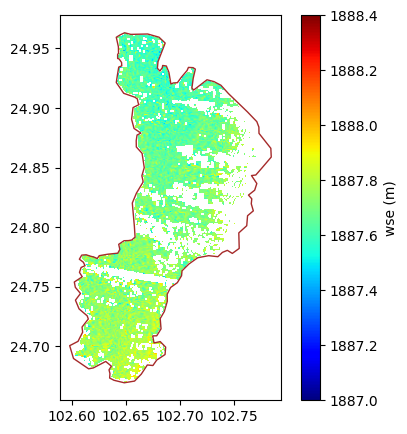

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
## ax0
im0 = ax.imshow(wse_IQR, cmap='jet', extent=raster_extent, vmin=1887, vmax=1888.4)
dianchi_gpd.plot(ax=ax, edgecolor='Brown', facecolor='none', linewidth=1)
fig.colorbar(im0).set_label('wse (m)')


In [12]:
print('Average wse:', np.nanmean(wse_IQR))
print('Standard deviation of wse: ', np.nanstd(wse_IQR))


Average wse: 1887.7032
Standard deviation of wse:  0.094600774


#### Combined tha above steps for time-series water level extraction

In [13]:
## get acquisition time 
dates_data = [path.split('_')[-4] for path in paths_file]
dates_data = [date[0:4]+'-'+date[4:6]+'-'+date[6:8]+'T'+date[9:11]+':'+date[11:13]+':'+date[13:15]
              for date in dates_data]

## convert date to decimal
dates_decimal = [dt64_to_dyr(date) for date in dates_data]
dates_decimal = [round(date, 5) for date in dates_decimal]
dates_decimal[2]



2024.12568

In [ ]:
wse_lake_mean, wse_lake_std = {}, {}
for i, path in enumerate(paths_file):
  print(i, path)
  date_decimal = dates_decimal[i]
  ## (1) data reading
  raster_nc = xr.open_dataset(path, decode_times=False)
  ## (2) outliers removing using IQR method.
  iter = 0
  wse_IQR, IQR = IQR_filter(raster_nc.wse.values)
  while IQR > 0.5:    
      iter += 1
      wse_IQR_mask = wse_IQR.mask
      wse_IQR, IQR = IQR_filter(wse_IQR.filled(np.nan))
      wse_IQR.mask = wse_IQR.mask | wse_IQR_mask
      if iter == 2: break   ## max iteration: 4 times.
  if IQR > 0.5: continue
  if (~wse_IQR.mask).sum() < 50: continue  ## the threshold of the number of valid measurements. 
  ## (3) lake level calculation (average and std of the wse).
  wse_lake_mean[date_decimal] = np.nanmean(wse_IQR)
  wse_lake_std[date_decimal] = np.nanstd(wse_IQR)


0 data/dianchi_lake/raster/SWOT_L2_HR_Raster_100m_UTM48R_N_x_x_x_009_049_099F_20240105T211638_20240105T211659_PGC0_01_masked.nc
1 data/dianchi_lake/raster/SWOT_L2_HR_Raster_100m_UTM48R_N_x_x_x_010_049_099F_20240126T180144_20240126T180205_PIC0_01_masked.nc
2 data/dianchi_lake/raster/SWOT_L2_HR_Raster_100m_UTM48R_N_x_x_x_011_049_099F_20240216T144649_20240216T144710_PIC0_01_masked.nc
3 data/dianchi_lake/raster/SWOT_L2_HR_Raster_100m_UTM48R_N_x_x_x_012_049_099F_20240308T113153_20240308T113214_PIC0_01_masked.nc
4 data/dianchi_lake/raster/SWOT_L2_HR_Raster_100m_UTM48R_N_x_x_x_013_049_099F_20240329T081657_20240329T081718_PIC0_01_masked.nc
5 data/dianchi_lake/raster/SWOT_L2_HR_Raster_100m_UTM48R_N_x_x_x_014_049_099F_20240419T050203_20240419T050224_PIC0_01_masked.nc
6 data/dianchi_lake/raster/SWOT_L2_HR_Raster_100m_UTM48R_N_x_x_x_015_049_099F_20240510T014706_20240510T014727_PIC0_01_masked.nc
7 data/dianchi_lake/raster/SWOT_L2_HR_Raster_100m_UTM48R_N_x_x_x_016_049_099F_20240530T223211_20240530T2

#### 5. plot the result.

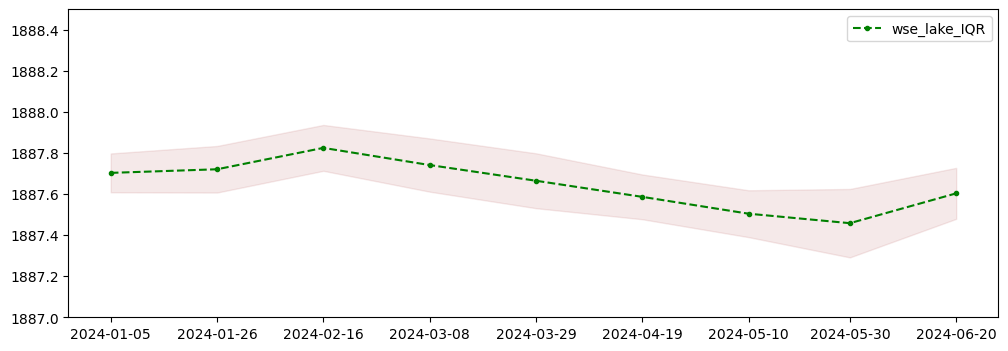

In [35]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(wse_lake_mean.keys(), wse_lake_mean.values(), '--.', color='green', label='wse_lake_IQR')
ax.fill_between(wse_lake_mean.keys(), np.array([*wse_lake_mean.values()]) - np.array([*wse_lake_std.values()]), \
                np.array([*wse_lake_mean.values()]) + np.array([*wse_lake_std.values()]), color='Brown', alpha=0.1)
ax.set_ylim([1887, 1888.5])
ax.set_xticks(list(wse_lake_mean.keys()))
ax.set_xticklabels(map(lambda date: date[0:10], dates_data))
ax.legend()
